In [1]:
import dask.dataframe as dd
import pandas as pd
!pip install fastparquet
from fastparquet import ParquetFile
pd.set_option('display.max_columns', None)

     |████████████████████████████████| 153kB 2.7MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 
  Created wheel for fastparquet: filename=fastparquet-0.4.0-cp36-cp36m-linux_x86_64.whl size=251897 sha256=cccf59798d647e4e3fc43d18726689df9ab54563765eed4ec24663f0cb211f42
  Stored in directory: /root/.cache/pip/wheels/2f/1d/6f/d10f8d2688469c279b71799a457a1fd8f35e5ba06e91b7d993
  Created wheel for thrift: filename=thrift-0.13.0-cp36-cp36m-linux_x86_64.whl size=345247 sha256=9fe95c34a52f57ab9d04dea7641d7cc81ab13d01b3c1e0d82f72e68396e8b421
  Stored in directory: /root/.cache/pip/wheels/02/a2/46/689ccfcf40155c23edc7cdbd9de488611c8fdf49ff34b1706e
Successfully built fastparquet thrift


In [2]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 2.7MB/s 


In [0]:
import re
from scipy.spatial.distance import cosine
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

import logging

import matplotlib.pyplot as plt
% matplotlib inline

# Load the dataset


In [4]:
#Loading reviews data
reviews = dd.read_parquet('https://tally-ai-dspt3.s3.amazonaws.com/yelp-restaurants/reviews.parquet.gzip')
reviews.head()

,review_id,business_id,reviews_stars,date,text
index,,,,,
0,ipufYjKx5saLVuDR6f6o0w,S9RoY_Smsh0a2JPo90bkdg,5,2017-08-21 02:03:08,Was there with a girlfriend at lunch time toda...
1,VNOhF-xUYguSjA01yx5nwA,S9RoY_Smsh0a2JPo90bkdg,2,2017-08-20 17:46:40,I thought my meal was OK. I ordered an omelett...
2,PMXYXphbbkx2TM80AtIpQQ,S9RoY_Smsh0a2JPo90bkdg,2,2015-12-10 17:53:39,It's just a breakfast not too fancy. Weak coff...
3,7hxilsquX34WXHYc80qLkw,S9RoY_Smsh0a2JPo90bkdg,1,2017-09-02 18:54:37,"Shoule be zero stars! So, we have been here a ..."
4,Xnf39DsDWqiv1wulL2NK9g,S9RoY_Smsh0a2JPo90bkdg,5,2017-04-30 05:33:08,I LOVE this place!!! I'm so happy they opened ...


In [5]:
#Loading business data
business = dd.read_csv('https://tally-ai-dspt3.s3.amazonaws.com/yelp-restaurants/business.csv', blocksize=None)
business.head()

,Unnamed: 0,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,state,business_stars
0,8,404 E Green St,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...",pQeaRpvuhoEqudo3uymHIQ,"Ethnic Food, Food Trucks, Specialty Food, Impo...",Champaign,"{'Monday': '11:30-14:30', 'Tuesday': '11:30-14...",1,40.110446,-88.233073,The Empanadas House,61820,5,IL,4.5
1,20,4508 E Independence Blvd,"{'RestaurantsGoodForGroups': 'True', 'OutdoorS...",CsLQLiRoafpJPJSkNX2h5Q,"Food, Restaurants, Grocery, Middle Eastern",Charlotte,NaN,0,35.194894,-80.767442,Middle East Deli,28205,5,NC,3.0
2,24,"15480 Bayview Avenue, unit D0110","{'RestaurantsTableService': 'False', 'Restaura...",eBEfgOPG7pvFhb2wcG9I7w,"Restaurants, Cheesesteaks, Poutineries",Aurora,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",1,44.010962,-79.448677,Philthy Phillys,L4G 7J1,4,ON,4.5
3,25,300 John Street,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...",lu7vtrp_bE9PnxWfA8g4Pg,"Japanese, Fast Food, Food Court, Restaurants",Thornhill,NaN,1,43.820492,-79.398466,Banzai Sushi,L3T 5W4,7,ON,4.5
4,30,13071 Yonge Street,"{'Ambience': ""{'touristy': False, 'hipster': F...",9sRGfSVEfLhN_km60YruTA,"Persian/Iranian, Turkish, Middle Eastern, Rest...",Richmond Hill,"{'Tuesday': '12:0-21:0', 'Wednesday': '12:0-21...",1,43.947011,-79.454862,Apadana Restaurant,L4E 1A5,3,ON,3.0


In [0]:
#Conver dd to pd dataframe
reviews = reviews.compute()

In [7]:
# Load pre-trained model tokenizer(vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 415793.10B/s]


In [34]:
# locate the records containing "awesome", "excellent" and "great"
reviews_tmp = reviews[reviews['text'].str.contains("^(?=.*awesome)(?=.*excellent)(?=.*clean).+",
                                   flags=re.IGNORECASE, regex=True)]
print(reviews_tmp.shape)
reviews_tmp

(654, 5)


,review_id,business_id,reviews_stars,date,text
index,,,,,
4248,0MlgqCeznOq6fTw_yZXLeg,72s7cTvPgI_meydNhX-JMA,5,2013-08-18 18:08:37,Vincent's has excellent food and awesome servi...
5820,dtMfGwj0qcWIwkMORFuiIw,5p5YW_5bMOSuLIQjkJPO3w,5,2016-05-07 20:38:55,"This place is awesome. Salvatore Di Scala, own..."
1636,cHC4hw-_IkZnHjbUUC1aWw,rcaPajgKOJC2vo_l3xa42A,4,2009-07-14 00:56:56,We've been meaning to try Bouchon the last few...
15611,H-VNxVQso94sE8hiaxI4gg,Dkx_UjNhbXB-P0oyKqbTPA,5,2013-06-29 11:39:13,"I was wandering the area and the clean sign, a..."
16265,qWkvzFo9Rv2IcW4sGYUSyA,N7WeIAIipjKwiaoE9ZtKoQ,5,2019-11-03 06:35:21,Just had my first opportunity to eat here. The...
...,...,...,...,...,...
8048,yQBCJzy29x7TDExROQmKzA,zaxK3ea92mvEBRy-jttngg,4,2019-03-13 03:29:10,I took my family down to the Las Vegas Strip o...
11736,nXv81YVuDSD2jfRVPKtcHQ,m9aFZk1f8tSv248YErbpQA,5,2017-09-13 23:56:08,I have been going to this place since 2013. Th...
12629,MdBKcuWBQWHQWDeiqIjYQA,gU9_PUEdOOoBaSM49SRObg,5,2019-07-13 22:15:31,Our first visit here was a family outing becau...


In [35]:
reviews.dtypes

review_id                object
business_id              object
reviews_stars             int64
date             datetime64[ns]
text                     object
dtype: object

In [37]:
text = reviews_tmp['text'].values[653]
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', 'awesome', 'place', '!', 'customer', 'service', 'was', 'excellent', '!', 'the', 'food', ',', 'although', 'inexpensive', ',', 'were', 'very', 'ta', '##sty', '.', 'we', 'got', 'the', 'chicken', 'burr', '##ito', 'and', 'they', 'were', 'very', 'good', '.', 'the', 'hot', 'sauce', '##s', 'were', 'also', 'very', 'good', 'and', 'fresh', '.', 'i', 'will', 'be', 'coming', 'back', 'and', 'i', 'recommend', 'it', '!', '!', 'overall', ',', 'extremely', 'clean', 'environment', 'with', 'a', 'good', 'din', '##e', 'in', 'experience', 'and', 'yu', '##mmy', 'food', '.', '[SEP]']


In [38]:
# Map the token strings to their vocabulary indices.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indices.
for tup in zip(tokenized_text, indexed_tokens):
  print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
awesome      12,476
place         2,173
!               999
customer      8,013
service       2,326
was           2,001
excellent     6,581
!               999
the           1,996
food          2,833
,             1,010
although      2,348
inexpensive  23,766
,             1,010
were          2,020
very          2,200
ta           11,937
##sty        21,756
.             1,012
we            2,057
got           2,288
the           1,996
chicken       7,975
burr         22,715
##ito         9,956
and           1,998
they          2,027
were          2,020
very          2,200
good          2,204
.             1,012
the           1,996
hot           2,980
sauce        12,901
##s           2,015
were          2,020
also          2,036
very          2,200
good          2,204
and           1,998
fresh         4,840
.             1,012
i             1,045
will          2,097
be            2,022
coming        2,746
back          2,067
and           1,998
i             1,045


In [39]:
# Mark each of the 15 tokens as belonging to sentence "1"
segments_ids = [1] * len(tokenized_text)
print(segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [0]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

# Load BERT base model

In [41]:
# Load pre-trained model(weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Lin

In [0]:
# Predict hidden states features for each layer
with torch.no_grad():
  encoded_layers, _ = model(tokens_tensor, segments_tensors)

In [43]:
print ("Number of layers:", len(encoded_layers))
layer_i = 0
print ("Number of batches:", len(encoded_layers[layer_i]))
batch_i = 0
print ("Number of tokens:", len(encoded_layers[layer_i][batch_i]))
token_i = 0
print ("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))

Number of layers: 12
Number of batches: 1
Number of tokens: 72
Number of hidden units: 768


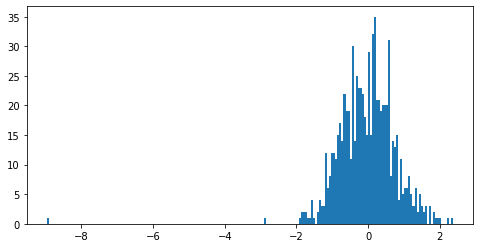

In [44]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = encoded_layers[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(8,4))
plt.hist(vec, bins=200)
plt.show()

In [45]:
# `encoded_layers` is a Python list.
print('Type of encoded_layers: ', type(encoded_layers))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', encoded_layers[0].size())

Type of encoded_layers:  <class 'list'>
Tensor shape for each layer:  torch.Size([1, 72, 768])


# Token Vectors

In [46]:
# Concatenate the tensors for all layers, using 'stack' to create a new dimension in the tensore.
token_embeddings = torch.stack(encoded_layers, dim=0)
token_embeddings.size()

torch.Size([12, 1, 72, 768])

In [47]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)
token_embeddings.size()

torch.Size([12, 72, 768])

In [48]:
# switch the "layers" and "tokens" dimensions
# Swap dimensions 0 and 1
token_embeddings = token_embeddings.permute(1,0,2)
token_embeddings.size()

torch.Size([72, 12, 768])

In [50]:
# Stores the token vectors, with shape[72 X 3,072]
token_vecs_cat = []

# 'token_embeddings' is a [72 X 12 X 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

  #'token' is a [12 X 768] tensor

  # Concatenate the vectors from the last 4 layers.
  # Each layer vector is 768 values, so 'cat_vec' length is 3,072.
  cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)

  # Use 'cat_vec' to represent 'token'.
  token_vecs_cat.append(cat_vec)

print(f'Shape is: {len(token_vecs_cat)} x {len(token_vecs_cat[0])}')

Shape is: 72 x 3072


In [51]:
# Stores the token vectors, with shape[72 x 768]
token_vecs_sum = []

# 'token_embeddings' is a [72 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

  #'token' is a [12 x 768] tensor

  # Sum the vectors from the last four layers.
  sum_vec = torch.sum(token[-4:], dim=0)

  # Use 'sum_vec' to represent 'token'.
  token_vecs_sum.append(sum_vec)

print(f'Shape is: {len(token_vecs_sum)} x {len(token_vecs_sum[0])}')

Shape is: 72 x 768


# Sentence Vectors

In [52]:
# encoded_layers has shape [12 x 1 x 72 x 768]

# token_vecs is a tensor with shape [72 x 768]
token_vecs = encoded_layers[11][0]

# Calculate the average of all 72 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

print(f"Our final sentence embedding vector of shape: {sentence_embedding.size()}")

Our final sentence embedding vector of shape: torch.Size([768])


# Token Vector Cosine Similarity

In [53]:
for i, token_str in enumerate(tokenized_text):
  print(i, token_str)

0 [CLS]
1 awesome
2 place
3 !
4 customer
5 service
6 was
7 excellent
8 !
9 the
10 food
11 ,
12 although
13 inexpensive
14 ,
15 were
16 very
17 ta
18 ##sty
19 .
20 we
21 got
22 the
23 chicken
24 burr
25 ##ito
26 and
27 they
28 were
29 very
30 good
31 .
32 the
33 hot
34 sauce
35 ##s
36 were
37 also
38 very
39 good
40 and
41 fresh
42 .
43 i
44 will
45 be
46 coming
47 back
48 and
49 i
50 recommend
51 it
52 !
53 !
54 overall
55 ,
56 extremely
57 clean
58 environment
59 with
60 a
61 good
62 din
63 ##e
64 in
65 experience
66 and
67 yu
68 ##mmy
69 food
70 .
71 [SEP]


In [54]:
print('First 5 vector values for 3 adjectives.')
print("awesome ", str(token_vecs_sum[1][:5]))
print("excellent ", str(token_vecs_sum[7][:5]))
print("clean ", str(token_vecs_sum[57][:5]))

First 5 vector values for 3 adjectives.
awesome  tensor([3.1501, 1.8711, 3.3543, 0.9830, 5.0123])
excellent  tensor([ 2.5189, -0.6275,  1.6777,  0.3667,  4.7254])
clean  tensor([ 0.8796, -0.9482,  1.7917,  1.2173,  2.7531])


In [55]:
# similarity between "awesome" and "excellent" in this sentence
similarity_1 = 1 - cosine(token_vecs_sum[1], token_vecs_sum[7])
# similarity between "awesome" and "clean" in this sentence
similarity_2 = 1 - cosine(token_vecs_sum[1], token_vecs_sum[57])

print('Vector similarity for  *similar*  meanings:  %.2f' % similarity_1)
print('Vector similarity for *different* meanings:  %.2f' % similarity_2)

Vector similarity for  *similar*  meanings:  0.66
Vector similarity for *different* meanings:  0.56


# Sentence Vector Cosine Similarity

In [72]:
# Locate the records containing "awesome", "excellent" and "clean" and create review_pos for these reviews
reviews_tmp = reviews[reviews['text'].str.contains("^(?=.*awesome)(?=.*excellent)(?=.*clean).+",
                                   flags=re.IGNORECASE, regex=True)]
reviews_pos = reviews_tmp[['text']]
print(reviews_pos.shape)
reviews_pos

(654, 1)


,text
index,
4248,Vincent's has excellent food and awesome servi...
5820,"This place is awesome. Salvatore Di Scala, own..."
1636,We've been meaning to try Bouchon the last few...
15611,"I was wandering the area and the clean sign, a..."
16265,Just had my first opportunity to eat here. The...
...,...
8048,I took my family down to the Las Vegas Strip o...
11736,I have been going to this place since 2013. Th...
12629,Our first visit here was a family outing becau...


In [73]:
# Locate reviews with "terrible", "disappointing", and "dirty" and create review_neg for these reviews
reviews_tmp1 = reviews[reviews['text'].str.contains("^(?=.*terrible)(?=.*disappointing)(?=.*dirty).+",
                                   flags=re.IGNORECASE, regex=True)]
reviews_neg = reviews_tmp1[['text']]
print(reviews_neg.shape)
reviews_neg

(51, 1)


,text
index,
14267,"I'm not sure what happened to this theater, bu..."
28025,"Ive been to Vegas buffets many time, but this ..."
20393,"Everything about this place is unwelcoming, co..."
8486,Terrible quality food. Prices are not competit...
20477,"Great spot, awesome views, nice outdoor patio...."
17251,"We LOVE Rubio's, however, this location is ter..."
25074,Wings Good. Nachos BAD I am mean REALLY bad. ...
3325,This has to be the worst restaurant in Las Veg...
8908,We did not cook our own steak as that wasn't r...


In [0]:
# Merging reviews_pos and reviews_neg
reviews_mix = pd.merge(reviews_pos, reviews_neg, on = "text", how="outer")

In [77]:
reviews_mix

,text
0,Vincent's has excellent food and awesome servi...
1,"This place is awesome. Salvatore Di Scala, own..."
2,We've been meaning to try Bouchon the last few...
3,"I was wandering the area and the clean sign, a..."
4,Just had my first opportunity to eat here. The...
...,...
700,My experience today at this Benihanna location...
701,My employer was hosting an event at the MGM Ga...
702,I have gone to Stoke's Grill over the years an...
703,"Ehhhh, defiantly not competition worthy BBQ. ..."


In [80]:
%%time
# choose 2 positive and 2 negative tips texts
indices = [1, 2, 703, 704]
embeddings = []

for idx in indices:
    text = reviews_mix.loc[idx, 'text']
    marked_text = "[CLS] " + text + " [SEP]"
    # Tokenize our sentence with the BERT tokenizer.
    tokenized_text = tokenizer.tokenize(marked_text)
    # Map the token strings to their vocabulary indices.
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    # Mark each of the 22 tokens as belonging to sentence "1".
    segments_ids = [1] * len(tokenized_text)
    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    # Predict hidden states features for each layer
    with torch.no_grad():
        encoded_layers, _ = model(tokens_tensor, segments_tensors)
    # Concatenate the tensors for all layers. We use `stack` here to
    # create a new dimension in the tensor.
    token_embeddings = torch.stack(encoded_layers, dim=0)
    # `token_vecs` is a tensor with shape [15 x 768]
    token_vecs = encoded_layers[11][0]
    # Calculate the average of all 15 token vectors.
    sentence_embedding = torch.mean(token_vecs, dim=0)
    embeddings.append(sentence_embedding)

CPU times: user 2.77 s, sys: 141 ms, total: 2.91 s
Wall time: 2.91 s


In [82]:
# print out sentences and their vector similarity
for i, e in enumerate(embeddings):
    similarity = 1 - cosine(embeddings[0], embeddings[i-3])
    print(reviews_mix.loc[indices[0], 'text'])
    print(reviews_mix.loc[indices[i-3], 'text'])
    print('Sentence vector similarity: %.2f' % similarity)
    print()

This place is awesome. Salvatore Di Scala, owner and Executive Chef greeted us at the door. One of the best Italian restaurants in the area! If you are looking for a restaurant that offers large portions, fresh EVERYTHING, and a clean and friendly atmosphere - is the place to dine. The service is excellent and the setting is romantic. Most important, the food is A+. I felt right at home. If you love Italian food, you have to try Naples 15. Great wine selection! HIGHLY HIGHLY RECOMMEND!!!
We've been meaning to try Bouchon the last few times we've been to Vegas, but for some reason we've just never nailed it down. We were able to stop for a quick bite right before our flight out. I think it was 5 o'clockish pm when we entered and sat at the bar. It was pretty quiet at that time but there was a constant in-flow of people as we ate. The bartender did a great job at setting us up to eat at the bar, almost makes you feel like you should eat all your meals at the bar! We ordered off the bar m